<a href="https://colab.research.google.com/github/jals-code-dump/Coursera_Capstone/blob/master/Final_Assignment_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialisation

Initialise range calculation function and import libraries required for the project

In [3]:
%cd C:\Users\alexc\OneDrive\Documents\GitHub\Coursera_Capstone
#color map for folium markers
import branca.colormap as cm
#for pauses between api calls
import time
import pandas as pd
import numpy as np
!pip install geocoder
import geocoder
import requests
import matplotlib.pyplot as plt
!pip install folium
import folium
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#function for returning distance in km using lat and long
from math import sin, cos, sqrt, atan2, radians
def range_calculate(lat, long, dest_lat, dest_long):  
  R = 6373.0
  lat = radians(lat)
  long = radians(long)
  dest_lat = radians(dest_lat)
  dest_long = radians(dest_long)
  dlon = dest_long - long
  dlat = dest_lat - lat
  a = (sin(dlat/2))**2 + cos(lat) * cos(dest_lat) * (sin(dlon/2))**2
  c = 2 * atan2(sqrt(a), sqrt(1-a))
  d = R * c
  return d


C:\Users\alexc\OneDrive\Documents\GitHub\Coursera_Capstone


#Data Cleaning and Classification

Loading the population by town-city dataset, cleaning and classifying the data

In [4]:
#loads the data set
towns_df = pd.read_csv('population by town-city.csv')
#remove additional columns
towns_df = towns_df[['Area', '2019']]
#rename columns
towns_df.columns = ['Town', 'Population']
#create a new column for size defaulted to 'other
towns_df['Size'] = "Other"

#iterate through data set, cleaning as required
for index, row in towns_df.iterrows():
  towns_df.iloc[index, 0] = towns_df.iloc[index, 0].replace("buadisp2011:", "")
  towns_df.iloc[index, 0] = towns_df.iloc[index, 0].replace(" BUASD", "")
  towns_df.iloc[index, 0] = towns_df.iloc[index, 0].replace(" BUA", "")
  string = towns_df.iloc[index, 0]
  i = 0
  i = string.find(" - ")
  if i != -1:
    towns_df.iloc[index, 0] = string[i+3:]
 
#classify towns that fall into the 'medium' town category
for index, row in towns_df.iterrows():
  #if population falls in med town category then change size to medium town
  if row['Population'] >= 25000 and row['Population'] <= 59999:
    towns_df.iloc[index, -1] = "Medium Town"

#save and output the dataset
towns_df.to_csv('classified_towns.csv')
towns_df.head()

,Town,Population,Size
0,Kexby,337,Other
1,Bradfield Heath,831,Other
2,Huntley,1131,Other
3,Swinefleet,770,Other
4,Foulsham,965,Other


#Geocoding

Here we geocode all towns, using ARCGIS API to get latitude and longitude

In [6]:
#load the classified dataset
towns_df = pd.read_csv('classified_towns.csv', index_col=0)
#create columns for lat and long with default value of ""
towns_df['Latitude'] = ""
towns_df['Longitude'] = ""

#iterate through the classified dataset, requesting and storing lat long values
for index, row in towns_df.iterrows():
  latlong = None
  #wait for response
  while latlong == None:
    #search for town name
    g = geocoder.arcgis('{}, United Kingdom'.format(row['Town']))
    #store the lat long
    latlong = g.latlng
    #extract lat long
  lat = str(latlong[0])
  long = str(latlong[1])
  #save lat long
  towns_df.iloc[index, -1] = long
  towns_df.iloc[index, -2] = lat

#save dataset and output
towns_df.to_csv('latlong_classified_towns.csv')
towns_df.head()

KeyboardInterrupt: ignored

#Venue Search

Using the foursquare API we get the amount of supermarkets within 7500m of each medium sized town

In [7]:
towns_df = pd.read_csv('latlong_classified_towns.csv', index_col=0)
towns_df['Supermarkets'] = 0

CLIENT_ID = '####' #Foursquare ID
CLIENT_SECRET = '####' #Foursquare Secret
VERSION = '20180605' # Foursquare API version
#maximum returns
LIMIT = 200
#radius in meters
radius = 7500
#category id for supermarkets
categoryId= '52f2ab2ebcbc57f1066b8b46'

# create URL
def create_url(lat, long):
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{},&radius={}&limit={}&categoryId={}'.format(
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION, 
      lat,
      long,
      radius, 
      LIMIT,
      categoryId)
  return url

#iterate through all medium towns
for index, row in towns_df[towns_df['Size'] == "Medium Town"].iterrows():
  #get latlong
  lat = row['Latitude']
  long = row['Longitude']
  #create url with lat long
  url = create_url(lat, long)
  try:
    #create api call, wait two seconds for a reply then add results to dataframe
    results = requests.get(url).json()["response"]['groups'][0]['items']
    time.sleep(2)
    for res in results:
      towns_df.iloc[index, -1] = towns_df.iloc[index, -1] + 1
  except:
    print("Skipping {}".format(index))

#save dataset and output
towns_df.to_csv('towns_food_stores.csv')
towns_df.head()

Skipping 4613


,Town,Population,Size,Latitude,Longitude,Supermarkets
0,Kexby,337,Other,53.36187,-0.69237,0
1,Bradfield Heath,831,Other,51.92532,1.10478,0
2,Huntley,1131,Other,51.87339,-2.40925,0
3,Swinefleet,770,Other,53.69073,-0.83406,0
4,Foulsham,965,Other,52.78051,1.01002,0


#Data Exploration

Here we show the variance of shops and population, with a scatter graph and correlation output

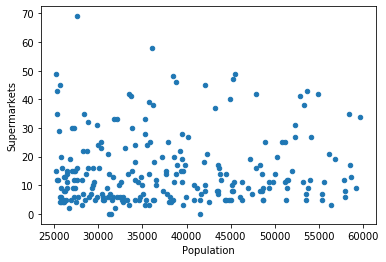

,Population,Supermarkets
Population,1.000000,0.056543
Supermarkets,0.056543,1.000000


In [8]:
#load dataset
towns_df = pd.read_csv('towns_food_stores.csv', index_col=0)
#mask to medium towns
towns_df = towns_df[towns_df['Size'] == 'Medium Town']
#plot population vs supermarkets
towns_df.plot(kind="scatter", x='Population', y='Supermarkets')
plt.show()
#show correlation
towns_df[['Population', 'Supermarkets']].corr()

#Data Exploration Continued

Here we show a map with markers based on search radius, in order to identify our erratic results

In [9]:
#load dataset
towns_df = pd.read_csv('towns_food_stores.csv', index_col=0)
#mask to medium towns
towns_df = towns_df[towns_df['Size'] == 'Medium Town']
#remove any erroneous entries
towns_df = towns_df[towns_df['Supermarkets'] != 0]

#create a map focused on UK
conv_map = folium.Map(location=[55.3781, -3.4360], zoom_start=7)
#loop through dataset, adding circles showing 7.5km radius around all medium towns
for index, row in towns_df.iterrows():
  lat = row['Latitude']
  long = row['Longitude']
  color = 'blue'#colormap(row['Supermarkets'])
  folium.Circle(location=[lat, long],radius=7500,fill=True,color=color,fill_opacity=0.5).add_to(conv_map)

conv_map

#Nearby Populations

Add Population of towns within 7.5, 10, 12.5 and 15km to new columns and then use this to identify a variable with better correlation

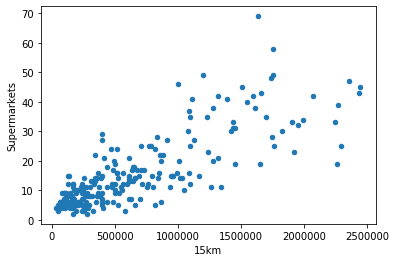

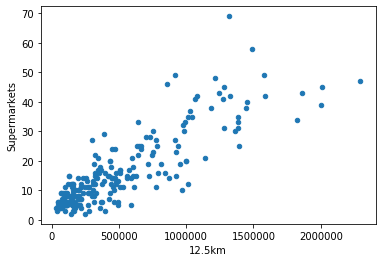

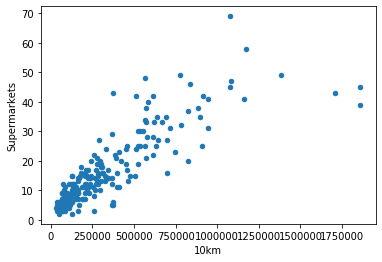

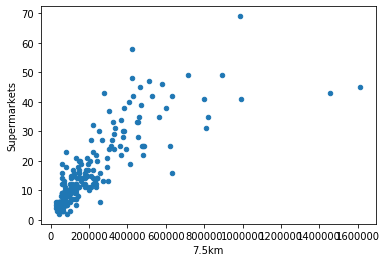

,Supermarkets,Population,7.5km,10km,12.5km,15km
Supermarkets,1.000000,0.051855,0.813293,0.854451,0.855032,0.801604
Population,0.051855,1.000000,0.030625,0.022111,0.048814,0.005489
7.5km,0.813293,0.030625,1.000000,0.878795,0.771736,0.704600
10km,0.854451,0.022111,0.878795,1.000000,0.880081,0.825582
12.5km,0.855032,0.048814,0.771736,0.880081,1.000000,0.924456
15km,0.801604,0.005489,0.704600,0.825582,0.924456,1.000000


In [15]:
#load the dataset, mask to medium towns and towns >0
towns_df = pd.read_csv('towns_food_stores.csv', index_col=0)
towns_df = towns_df[towns_df['Size'] == 'Medium Town']
towns_df = towns_df[towns_df['Supermarkets'] != 0]
towns_df.reset_index(inplace=True, drop=True)
#create empty columns for nearby population
towns_df['7.5km'] = 0
towns_df['10km'] = 0
towns_df['12.5km'] = 0
towns_df['15km'] = 0

#load locations data
loc_df = pd.read_csv('latlong_classified_towns.csv', index_col=0)

#loop through towns, saving population
for index, row in towns_df.iterrows():
  source_town = row['Town']
  source_lat = row['Latitude']
  source_long = row['Longitude']
  towns_df.iloc[index, -4:] = row['Population']
  for i, r in loc_df.iterrows():
    dest_town = r['Town']
    dest_lat = r['Latitude']
    dest_long = r['Longitude']
    #if the two towns being compared arent the same then calculate range and add population
    if source_town != dest_town:
      distance = range_calculate(source_lat,source_long,dest_lat,dest_long)
      if distance <= 7.5:
        towns_df.iloc[index, -4] = towns_df.iloc[index, -4] + r['Population']
      if distance <= 10:
        towns_df.iloc[index, -3] = towns_df.iloc[index, -3] + r['Population']
      if distance <= 12.5:
        towns_df.iloc[index, -2] = towns_df.iloc[index, -2] + r['Population']
      if distance <= 15:
        towns_df.iloc[index, -1] = towns_df.iloc[index, -1] + r['Population']

#plot all four search radius as scatter graphs
towns_df.head()
towns_df.plot(kind='scatter', x='15km', y='Supermarkets')
plt.show()
towns_df.plot(kind='scatter', x='12.5km', y='Supermarkets')
plt.show()
towns_df.plot(kind='scatter', x='10km', y='Supermarkets')
plt.show()
towns_df.plot(kind='scatter', x='7.5km', y='Supermarkets')
plt.show()
towns_df[['Supermarkets', 'Population', '7.5km', '10km', '12.5km', '15km']].corr()

#save the dataset
towns_df.to_csv('towns_with_local_pop.csv')

#Linear Regression

Here we test a Linear Regression model for 7.5, 10, 12.5 and 15km populations and look at the accuracy results.

In [11]:
#load the dataset
towns_df = pd.read_csv('towns_with_local_pop.csv', index_col=0)

#create a linear regression model
lr = LinearRegression()

#create an empty list for storing results
results = []
#list for iterating through population columns
pops = ['7.5km', '10km', '12.5km', '15km']
#loop through all population values, fitting linear regression models on training data and then testing on split test data
for n, pop in enumerate(pops):
  x = towns_df[pop]
  y = towns_df['Supermarkets']
  #assign population as x
  x = np.array(x).reshape([-1, 1])
  #assign supermarkets as y
  y = np.array(y).reshape([-1, 1])
  #split data
  xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=0)
  #fit the model
  lr.fit(xtrain, ytrain)
  #predict based on test population
  yhat = lr.predict(xtest)
  #calculate scores
  r2 = (r2_score(ytest, yhat))
  abso = (np.mean(np.absolute(yhat - ytest)))
  mse = (np.mean((yhat-ytest)**2))
  #append results to list
  results.append([pop, r2, abso, mse, lr.coef_, lr.intercept_])

#output the test results
res_df = pd.DataFrame(data=results, columns=['Population Range', 'R2 Score', 'Absolute Error', 'MSE', 'Coefficient', 'Intercept'])
res_df.head()

,Population Range,R2 Score,Absolute Error,MSE,Coefficient,Intercept
0,7.5km,0.707620,4.522759,37.694800,[[4.2656411724433755e-05]],[6.902638416469408]
1,10km,0.676147,4.189261,41.752447,[[3.208400021279516e-05]],[5.315847331377228]
2,12.5km,0.690203,4.158165,39.940181,[[2.3279458547277628e-05]],[4.343536946384052]
3,15km,0.495643,5.454379,65.023644,[[1.7597800209856766e-05]],[4.261747255495212]


#Visualising Requirements pt1

Here we show the results of the current supermarkets in each town vs the estimated requirement

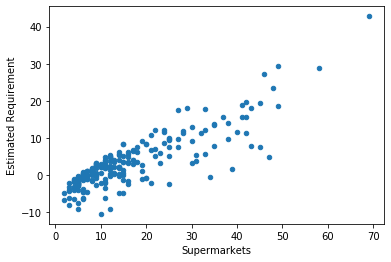

In [12]:
#load the data set and add an empty column for estimated requirements
towns_df = pd.read_csv('towns_with_local_pop.csv', index_col=0)
towns_df['Estimated Requirement'] = 0
#the coef and intercept as shown from the linear regression model
coef = 1.63905761e-05
inter = 4.61262226

#loop through the dataset, adding results of applying the linear model to each town
for index, row in towns_df.iterrows():
  towns_df.iloc[index, -1] = row['Supermarkets'] - (inter + row['12.5km'] * coef)

#plot the results as a scatter graph and save the dataframe for later
towns_df.plot(kind='scatter', x='Supermarkets', y='Estimated Requirement')
towns_df.to_csv('towns_with_requirements.csv')

#Visualising Requirements pt2

Here we show each medium sized town with a requirement of more than 0, with the search radius in blue and the fill based on the requirements as per the legend

In [13]:
#load dataset
towns_df = pd.read_csv('towns_with_requirements.csv', index_col=0)

#create a colormap to use as the legend
colormap = cm.LinearColormap(colors=['red', 'green'], vmin=0, vmax=10, caption="Estimated Supermarket Requirements")

#create a folium map centred on the UK
conv_map = folium.Map(location=[55.3781, -3.4360], zoom_start=7)
#loop through the dataset, adding circles based on requirements if over 0
for index, row in towns_df.iterrows():
  if row['Estimated Requirement'] >= 0:
    lat = row['Latitude']
    long = row['Longitude']
    #create the tooltip for hovering over locations
    tooltip = ("Estimated requirements for Supermarkets:" + str(row['Estimated Requirement'])[0:3])
    folium.Circle(location=([lat,long]), fill_opacity=0.5,
                  fill_color=colormap(row['Estimated Requirement']),
                  tooltip=tooltip, radius=7500).add_to(conv_map)

#add the legend and show map
conv_map.add_child(colormap)
conv_map

#Visualising Requirements pt3
Here we visualise the top ten and bottom ten towns in order of Estimated Requirement

Text(0.5, 0, 'Estimated Requirement')

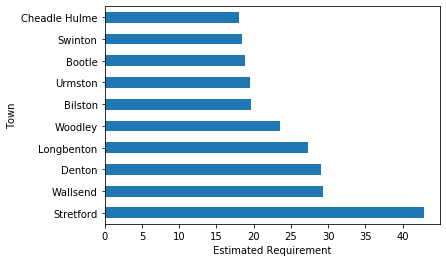

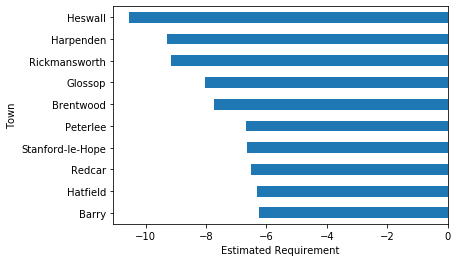

In [14]:
#load data set, sort by requirements, take top ten and bottom rows
towns_df = pd.read_csv('towns_with_requirements.csv', index_col=0)
towns_df.sort_values('Estimated Requirement', inplace=True, ascending=False)
top_ten = towns_df.iloc[:10, :]
bottom_ten = towns_df.iloc[-10:, :]

#plot top ten as bar chart
top_ten.plot(kind='barh', x='Town', y='Estimated Requirement')
plt.legend().remove()
plt.xlabel('Estimated Requirement')
#plot bottom ten as bar chart
bottom_ten.plot(kind='barh', x='Town', y='Estimated Requirement')
plt.legend().remove()
plt.xlabel('Estimated Requirement')